# Verificador Entregas
 
1. Poner una celda de markdown por carpeta (extraer nombre)
2. Luego copiar contenido de cada archivo .py en una celda de código.
3. Crea un cuaderno general con todas las entregas, y uno individual para retroalimentación del estudiante

## Uso

Copiar este cuaderno en la raiz de la carpeta donde se descomprimió la entrega en Aula Digital, luego ejecutarlo todo.


In [17]:
%reset -sf

extensions = [
    '.py',
    'otra_ext'
]

import os
from pathlib import Path

import tkinter as tk
from  tkinter import filedialog

root = tk.Tk()
root.withdraw()

''

## Procesar carpeta con archivos comprimidos o con carpetas descomprimidas

Requiere: 
- una carpeta con los .zip generados por Aula Digital
    - Con esta opción, descomprime los .zip y genera carpetas con consecutivos
o
- una carpeta con las subcarpetas de las evaluaciones.
    - Con esta opción, solo identifica las subcarpetas
    
El resultado es la lista ```basepaths```

In [18]:
rootpath = Path(filedialog.askdirectory())
# rootpath = Path(r"C:\Users\000092114\UPB\Fundamentos de Computacion 2022-20 - Profesores - Profesores\_notas\seg1\Test")
basepaths = []
content = rootpath.glob('*/')
contList = [Path(x) for x in content]
folders = [x for x in contList if x.is_dir()]
files = [x for x in contList if x.is_file() and x.suffix == ".zip"]
# print(folders)
# print(files)
generateNB = False
if folders == [] and files != []: # si no se ha descomprimido nada y hay .zips por descomprimir
    from zipfile import ZipFile
    grupo = 1
    # ahora se define el nombre de la carpeta con un consecutivo.
    for file in files:
        # Create a ZipFile Object and load sample.zip in it
        with ZipFile(str(file), 'r') as zipObj:
           # Extract all the contents of zip file in different directory
            zipObj.extractall(file.parent/str(grupo))
            generateNB = True
        basepaths.append(file.parent/str(grupo))
        grupo += 1
elif folders != []:
    basepaths = folders
    
print(basepaths)

[WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/1'), WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/2')]


## Procesar los archivos

In [23]:
pathList,nameList,scriptList = list(),list(),list()
for basepath in basepaths:
    for entry in os.listdir(basepath):
        entry = Path(entry)
        if str(entry).endswith("_assignsubmission_file_"):
            #agregue el path de la carpeta a la lista de paths
            pathList.append(basepath/entry)
            #agregue el nombre a la lista de nombres (extraido del nombre de la entrega)
            nameList.append(str(entry).split("_")[0])
            #recoja todos los archivos de cada entrega
            p = pathList[-1].glob("**/*")
            #solo guarde los que estén en la lista de extensiones (para evitar que coja los cuadernos)
            scriptList.append([x for x in p if x.is_file() and x.suffix in extensions])
    
print(scriptList)
    # leer el contenido del archivo como texto
    #print(scriptList[-1][-1].read_text())

[[WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/1/Ayala Garcia Andrea_2708957_assignsubmission_file_/Taller semana 5.py')], [WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/1/Betancur Zapata Lady Estefany_2708963_assignsubmission_file_/Ejercicios tarea 18 agosto FC.py')], [WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/1/Echeverry Correa Maria Catalina_2708966_assignsubmission_file_/Tarea clase.py')], [WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/1/Jaramillo Londoño Andrea_2708958_assignsubmission_file_/EJERCICIO 5.py')], [WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computacion 2022-20 - Profesores - Profesores/_notas/seg1/S5/1/Lopera Otero David_2708977_assignsubmission_file_/taller 5.py')], [WindowsPath('C:/Users/LMAG/UPB/Fundamentos de Computa

## Creación de cuadernos individuales por estudiante con el reporte

### Importar módulos y definición de funciones

**Atención**: solo correr si se requiere generar los cuadernos de retroalimentación.

In [24]:
if generateNB:

    import nbformat as nbf
    import itertools 

    def conformarCeldas(cuaderno,nombre,scripts):
        cellsList = list()
        text = f"""\
    # {nombre}
    """
        cellsList.append(nbf.v4.new_markdown_cell(text))
        code = f"""\
    %%javascript
    IPython.notebook.events.off('checkpoint_created.Notebook');
    IPython.notebook.events.off('notebook_saved.Notebook');
    """
        cellsList.append(nbf.v4.new_code_cell(code))

        for script in scripts:
            try:
                codeText = script.read_text(encoding="utf8")
            except:
                print(f"fallo lectura de codigo en {script}")
                return cellsList
            code = f"""\
    # {script.stem}\n
    %reset -sf\n#para correr el script desde cero, esta linea no afectara la ejecución de su codigo.\n
    {codeText}"""
            cellsList.append(nbf.v4.new_code_cell(code))
        return cellsList

### Crear cuadernos con script por celda de código

Se pone el nombre del estudiante en una celda de markdown
Luego se crea una celda de código por programa, con un comentario con el nombre del archivo.

In [25]:
if generateNB:

    for (estPath,estName,estScripts) in zip(pathList,nameList,scriptList):

        nb = nbf.v4.new_notebook()

        celdas = conformarCeldas(nb,estName,estScripts)

        nb['cells'] = celdas
        nbf.write(nb, estPath/f'{estName}.ipynb')

### Verificar similaridad

Correr estas celdas individualmente.
1. Conformar la lista de scripts y estudiantes consolidada
2. correr la celda para generar el mapa de similaridad

In [26]:
# generar mapa de similaridad
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
dimension = len(scriptList)
similarity = np.zeros((dimension,dimension))
for i,script_base in enumerate(scriptList):
    for j,script_cmp in enumerate(scriptList):
        with open(script_base[0], errors='ignore') as fileA,open(script_cmp[0], errors='ignore') as fileB:
            fileAData = fileA.read()
            fileBData = fileB.read()
            similarity[[i],[j]] = int(SequenceMatcher(None, fileAData,fileBData).ratio()*100)
#             if similarity>0.8:
#             print( f"{nameList[i]} se asemeja en: {similarity[i][j]*100:.2f} % a {nameList[j]}.")
#             else:
#                 print("Plagiarism is: {0:.2f}".format(similarity*100),"%, no copia.")

df = pd.DataFrame(similarity, columns = nameList, index = nameList)

## Por hacer

Generar una lista de parejas de personas con similaridad mayor a cierto umbral, luego llamar al comparador con interfaz gráfica: https://github.com/yebrahim/pydiff

- Generar parejas de similares con mayor a umbral
- Verificar uso de la herramienta llamada desde cli.
- Sistematizar la revisión de comparación

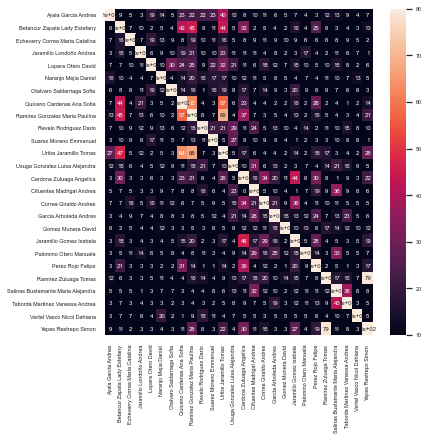

In [28]:
# print(df)
sns.set(font_scale=0.5)
figure = plt.gcf() # get current figure
figure.set_size_inches(6, 6)
mapa = sns.heatmap(df, annot=True, vmin = 10, vmax = 80)
plt.savefig(rootpath/'mapaSimilaridad.pdf', dpi=300,bbox_inches='tight')

### Crear un cuaderno con todos los códigos para comparación y verificación de fraudes

In [30]:
import "\\Documents\\pydiff\\pydiff.py"

# nb = nbf.v4.new_notebook()
# for (estPath,estName,estScripts) in zip(pathList,nameList,scriptList):
#     celdas = conformarCeldas(nb,estName,estScripts)
    
#     nb['cells'] += celdas
# nbf.write(nb, 'RevisionEntregas.ipynb')

SyntaxError: invalid syntax (<ipython-input-30-c8e1b5d1b1a8>, line 1)

### Refs

https://nbviewer.org/gist/fperez/9716279

https://github.com/yebrahim/pydiff